# Transfer Learning with MobileNetV2

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation, RandomRotation, RandomZoom

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<a name='1'></a>
## 2 - Datasets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 21
datasets = [
    ('datasets\\cropped\\continental', 0.01),
    ('datasets\\cropped\\indian_0', 0.2),
    ('datasets\\cropped\\indian_1', 0.2),
    ('datasets\\fruits-360\\Training', 0.02),
]
fruit360_classes = None

train_dataset = image_dataset_from_directory(
    'datasets\\all_classes',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical',
    validation_split=0.5,
    subset='training',
    seed=SEED,
)
all_class_names = train_dataset.class_names

cv_dataset = image_dataset_from_directory(
    'datasets\\all_classes',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical',
    validation_split=0.5,
    subset='validation',
    seed=SEED,
)
for directory, split in datasets:
    dataset = image_dataset_from_directory(
        directory,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical',
        validation_split=split,
        subset='training',
        seed=SEED,
    )
    if 'fruits-360' in directory:
        fruit360_classes = dataset.class_names
    train_dataset = train_dataset.concatenate(dataset)
        
    dataset = image_dataset_from_directory(
        directory,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        label_mode='categorical',
        validation_split=split,
        subset='validation',
        seed=SEED,
    )
    cv_dataset = cv_dataset.concatenate(dataset)
    print()

print(
    tf.data.experimental.cardinality(train_dataset),
    train_dataset,
    sep = '\n'
)

Found 594 files belonging to 297 classes.
Using 297 files for training.
Found 594 files belonging to 297 classes.
Using 297 files for validation.
Found 100000 files belonging to 100 classes.
Using 99000 files for training.
Found 100000 files belonging to 100 classes.
Using 1000 files for validation.

Found 2734 files belonging to 20 classes.
Using 2188 files for training.
Found 2734 files belonging to 20 classes.
Using 546 files for validation.

Found 4000 files belonging to 80 classes.
Using 3200 files for training.
Found 4000 files belonging to 80 classes.
Using 800 files for validation.

Found 89089 files belonging to 97 classes.
Using 87308 files for training.
Found 89089 files belonging to 97 classes.
Using 1781 files for validation.

tf.Tensor(6002, shape=(), dtype=int64)
<ConcatenateDataset shapes: ((None, 224, 224, 3), (None, None)), types: (tf.float32, tf.float32)>


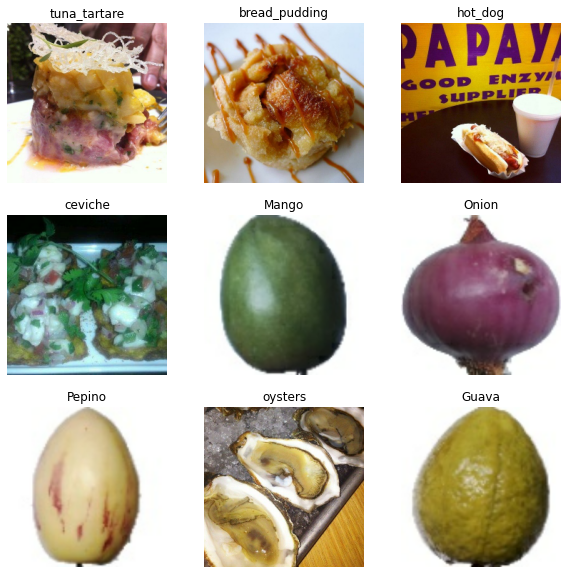

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i+9].numpy().astype("uint8"))
        plt.title(all_class_names[tf.math.argmax(labels[i+9])])
        plt.axis("off")

<a name='2'></a>
## 3 - Preprocess and Augment Training Data
(https://www.tensorflow.org/tutorials/images/data_augmentation).

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
shuffled_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)

In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomZoom((-0.2, 0)))
    data_augmentation.add(RandomRotation(0.15))
    return data_augmentation


def data_augmenter_fruit360():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(
        RandomZoom(
            (1, 1), 
            fill_mode='constant', 
            fill_value=255
        )
    )
    data_augmentation.add(
        RandomTranslation(
            (-0.25, 0.2), 
            (-0.25, 0.2), 
            fill_mode='constant', 
            fill_value=255
        )
    )
    data_augmentation.add(
        RandomRotation(
            1, 
            fill_mode='constant', 
            fill_value=255
        )
    )
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from.

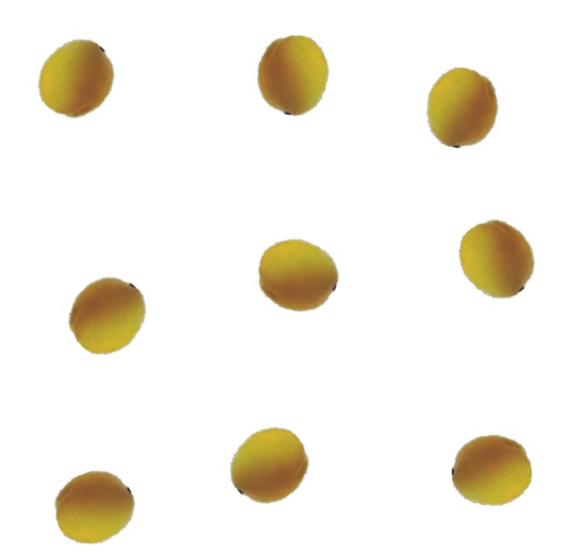

In [6]:
data_augmentation = data_augmenter_fruit360()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

<a name='3'></a>
## 4 - Using MobileNetV2 for Transfer Learning 


Let's try to train your base model using all the layers from the pretrained model. 

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`. 

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

mobile_v3_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

Print the model summary below to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable. 

In [8]:
mobile_v3_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [9]:
print("Number of layers in the base model: ", len(mobile_v3_model.layers))
len(mobile_v3_model.layers)

Number of layers in the base model:  276


276

In [10]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape, label_batch.shape)

(32, 224, 224, 3) (32, 297)


<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [27]:
#Loss function
def CrossentropyLoss(label, prediction):
    epsilon = tf.constant(0.00001)
    log_pred = tf.math.log(prediction + epsilon, name='Prediction_Log')
    log_pred_2 = tf.math.log(1-prediction + epsilon, name='1-Prediction_Log')

    cross_entropy = -tf.multiply(label, log_pred) - tf.multiply((1-label), log_pred_2) 
    return tf.math.reduce_mean(
        cross_entropy
    )


<a name='ex-2'></a>
### model

In [30]:
def isin(a, b):
    tile_multiples = tf.concat(
        [
            tf.ones(tf.shape(tf.shape(a)), dtype=tf.int32), 
            tf.shape(b)
        ],
        axis=0
    )
    a_tile = tf.tile(tf.expand_dims(a, -1), tile_multiples)
    a_tile = tf.cast(a_tile, dtype=tf.int32)
    a_in_b = tf.reduce_any(tf.equal(a_tile, b), -1)
    return a_in_b


class CustomModel(tf.keras.Model):
    food_augmenter = data_augmenter()
    fruit_augmenter = data_augmenter_fruit360()
    fruit_indices = tf.constant(
        [all_class_names.index(fruit) for fruit in fruit360_classes]
    )

    def train_step(self, data):
        x, y = data
        class_indices = tf.math.argmax(y, -1)
        isfr = isin(class_indices, self.fruit_indices)
        isfr = tf.expand_dims(tf.expand_dims(tf.expand_dims(isfr, -1), -1), -1)
        x = tf.where(
            isfr, 
            self.fruit_augmenter(x), 
            self.food_augmenter(x),
        )
        return super().train_step((x, y))


def food_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
    )
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 259

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x) 
    
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    
    x = tfl.Dense(640, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.1)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(297, activation='softmax')
    
    outputs = prediction_layer(x) 
    model = CustomModel(inputs, outputs)
    
    return model

model2 = food_model()
model2.summary()

Model: "custom_model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 640)               819840    
_________________________________________________________________
dropout_15 (Dropout)         (None, 640)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 297)               190377    
Total params: 5,236,649
Trainable params: 2,549,737
Non-trainable params: 2,686,912
_________________________________

### Estimate optimal learning rate

In [31]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batches = 200
        l, r = -5, -1
        self.exp_lrs = np.arange(l, r, step=(r-l)/self.batches)
        
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_batch_begin(self, batch, logs={}):
        lr = np.power(10, self.exp_lrs[batch])
        K.set_value(self.model.optimizer.lr, lr)

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs['loss'])


history = LossHistory()
optimizer = tf.keras.optimizers.Adam()

model2 = food_model(IMG_SIZE)
model2.compile(
    loss=CrossentropyLoss,
    optimizer=optimizer,
)
model2.fit(
    shuffled_dataset.take(history.batches),
    callbacks=[history],
)
    
plt.figure(figsize=(8, 8))
plt.plot(history.exp_lrs, history.losses)
plt.ylabel('Loss')
plt.xlabel('Learning Rate Exponent')
plt.title('Training Loss')

InvalidArgumentError:  required broadcastable shapes at loc(unknown)
	 [[node CrossentropyLoss/Mul (defined at <ipython-input-27-278a4381ffe1>:7) ]] [Op:__inference_train_function_165934]

Errors may have originated from an input operation.
Input Source operations connected to node CrossentropyLoss/Mul:
 IteratorGetNext (defined at <ipython-input-31-7393c2da41c1>:26)	
 CrossentropyLoss/Prediction_Log (defined at <ipython-input-27-278a4381ffe1>:4)

Function call stack:
train_function


In [ ]:
optimizer = tf.keras.optimizers.Adam()

# evaluation metrics
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5'),
]

### END CODE HERE

model2 = food_model(IMG_SIZE)
model2.compile(
    loss=CrossentropyLoss,
    optimizer=optimizer,
    metrics=metrics,
)

In [ ]:
class LRCallBack(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.epochs = 5
        l, r = -2.75, -4.75
        self.exp_lrs = np.arange(l, r, step=(r-l)/self.epochs)
        
    def on_epoch_begin(self, epoch, logs={}):
        lr = np.power(10, self.exp_lrs[epoch])
        K.set_value(self.model.optimizer.lr, lr)
        print('lr set to:', lr)

    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs['loss'])


tqdm_callback = tfa.callbacks.TQDMProgressBar()
lr_callback = LRCallBack()

history = model2.fit(
    shuffled_dataset, 
    validation_data=cv_dataset, 
    epochs=lr_callback.epochs,
    verbose=0,
    callbacks=[tqdm_callback, lr_callback],
)
history.history['accuracy']

plt.figure(figsize=(8, 8))
plt.plot(lr_callback.batch_losses)
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.title('Training Loss')

Plot the training and validation accuracy:

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.05])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<a name='ex-3'></a>
### Fine Tuning

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 